In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf
from learntools.time_series.utils import seasonal_plot, plot_periodogram
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
plot_params = {
    "color": "0.75",
    "style": ".-",
    "markeredgecolor": "0.25",
    "markerfacecolor": "0.25",
    "legend": False,
}

logger.setLevel(logging.DEBUG)

In [3]:
# get data
def get_data() -> pd.DataFrame:
    df = pd.read_csv("datasets/train.csv", parse_dates=["date"])
    df = df[["date", "item", "sales"]]
    df = df.set_index("date")

    logger.debug(f"Data shape: {df.shape}")
    logger.debug(df.head())

    # group data by date and item
    df = df.groupby(["date", "item"]).sum().reset_index()

    logger.debug(f"Data shape: {df.shape}")
    logger.debug(df.head())

    # show dates ranges
    logger.debug(f"Date range: {df.date.min()} - {df.date.max()}")

    return df

In [4]:
# montly seasonality
def monthly_sales(df: pd.DataFrame) -> None:
    df = df[["date", "sales"]]
    df["date"] = df["date"].dt.to_period("M")
    df = df.groupby("date").sum().reset_index()
    df["date"] = df["date"].dt.to_timestamp()

    plt.figure(figsize=(15, 5))
    plt.plot(df["date"], df["sales"])
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title("Monthly Sales")
    plt.show()

In [5]:
# weekly seasonality
def weekly_sales(df: pd.DataFrame) -> None:
    df = df[["date", "sales"]]
    df["date"] = df["date"].dt.to_period("D")
    df = df.groupby("date").sum()
    df["week"] = df.index.week
    df["day"] = df.index.dayofweek

    seasonal_plot(df, y="sales", period="week", freq="day")
    plt.show()

In [6]:
def yearly_sales(df: pd.DataFrame) -> None:
    df = df[["date", "sales"]]
    df["date"] = df["date"].dt.to_period("M")
    df = df.groupby("date").sum()
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear

    seasonal_plot(df, y="sales", period="year", freq="dayofyear")
    plt.show()

In [7]:
def check_periodogram(df: pd.DataFrame) -> None:
    df = df[["date", "sales"]]
    df["date"] = df["date"].dt.to_period("M")
    df = df.groupby("date").sum()

    plot_periodogram(df["sales"])
    plt.show()

In [8]:
# feature data anaylsis
def make_analysis(df: pd.DataFrame) -> None:
    monthly_sales(df.copy())
    weekly_sales(df.copy())
    yearly_sales(df.copy())
    check_periodogram(df.copy())
    plot_pacf(df.copy()["sales"], lags=12)

/var/folders/y_/tqdmcpj93n34bc271lhysl0w0000gn/T/ipykernel_14997/2234484888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df["date"].dt.to_period("M")


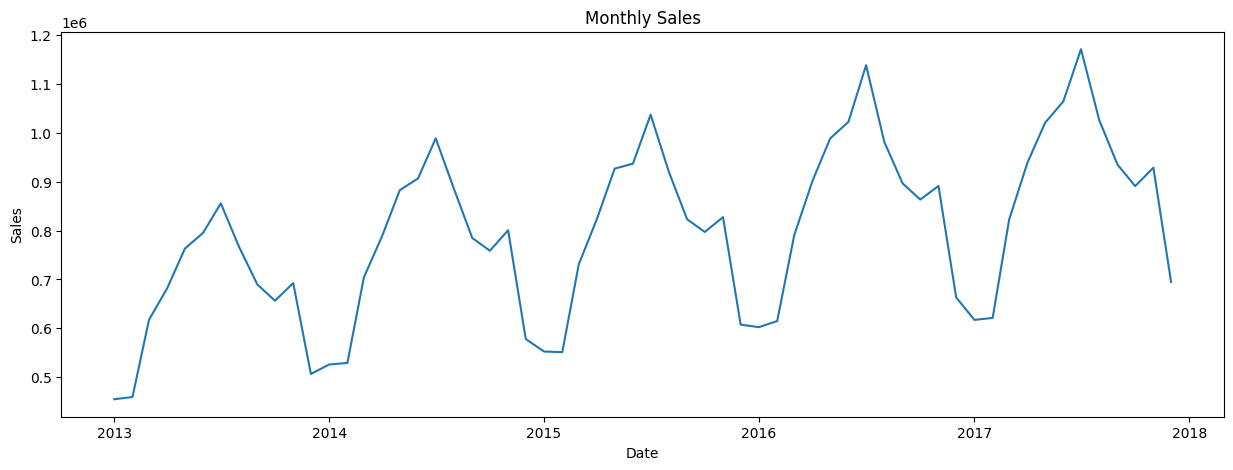

/var/folders/y_/tqdmcpj93n34bc271lhysl0w0000gn/T/ipykernel_14997/511239294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df["date"].dt.to_period("D")
/Users/lucasmaia/opt/miniconda3/envs/dl/lib/python3.10/site-packages/learntools-0.3.4-py3.10.egg/learntools/time_series/utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



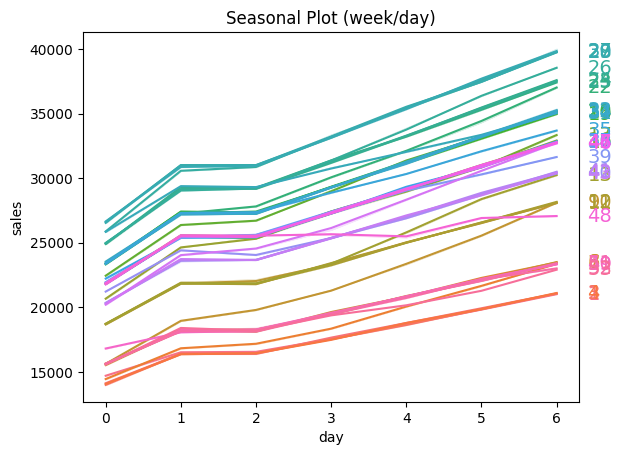

/var/folders/y_/tqdmcpj93n34bc271lhysl0w0000gn/T/ipykernel_14997/2724952657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df["date"].dt.to_period("M")
/Users/lucasmaia/opt/miniconda3/envs/dl/lib/python3.10/site-packages/learntools-0.3.4-py3.10.egg/learntools/time_series/utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



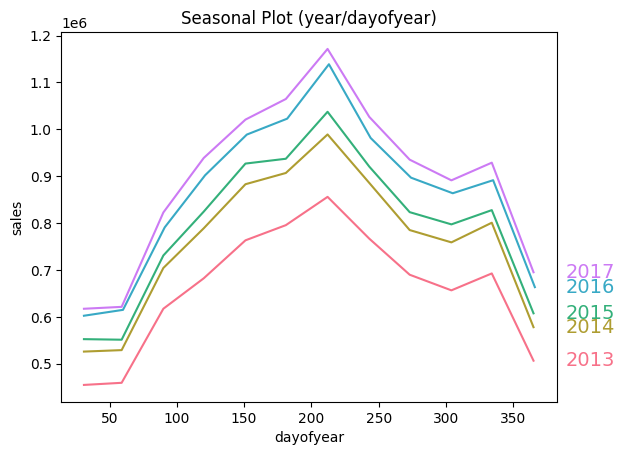

/var/folders/y_/tqdmcpj93n34bc271lhysl0w0000gn/T/ipykernel_14997/2832370181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = df["date"].dt.to_period("M")


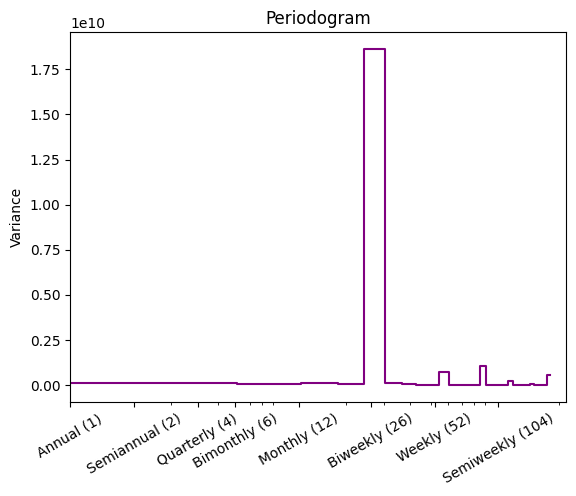

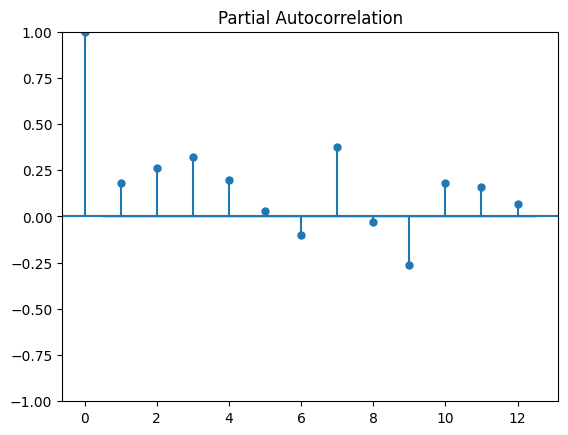

In [9]:
logger.setLevel(logging.DEBUG)
df = get_data()
make_analysis(df)

In [10]:
def feature_engineering(df: pd.DataFrame, lag_range=12) -> pd.DataFrame:
    # Converting 'date' to datetime and creating 'year_month'
    df["date"] = pd.to_datetime(df["date"])
    df["year_month"] = df["date"].dt.to_period("M")

    # Aggregating sales data monthly
    sales_monthly = (
        df.groupby(["year_month", "item"])["sales"]
        .agg(total_sales=("sum"))
        .reset_index()
    )

    # Calculating the difference for 'total_sales'
    sales_monthly["total_sales_diff"] = sales_monthly.groupby("item")[
        "total_sales"
    ].diff()
    sales_monthly.set_index("year_month", inplace=True)
    sales_monthly.dropna(inplace=True)

    # Creating lagged columns for 'total_sales_diff'
    for lag in range(1, lag_range + 1):
        sales_monthly[f"total_sales_diff_lag_{lag}"] = sales_monthly.groupby("item")[
            "total_sales_diff"
        ].shift(lag)

    # Drop rows with NaN values
    sales_monthly = sales_monthly.dropna()

    return sales_monthly

In [11]:
data = feature_engineering(df.copy())

In [12]:
data.head()

,item,total_sales,total_sales_diff,total_sales_diff_lag_1,total_sales_diff_lag_2,total_sales_diff_lag_3,total_sales_diff_lag_4,total_sales_diff_lag_5,total_sales_diff_lag_6,total_sales_diff_lag_7,total_sales_diff_lag_8,total_sales_diff_lag_9,total_sales_diff_lag_10,total_sales_diff_lag_11,total_sales_diff_lag_12
year_month,,,,,,,,,,,,,,,
2014-02,1,4391,68.0,14.0,-1649.0,461.0,-196.0,-799.0,-615.0,368.0,441.0,515.0,593.0,1327.0,69.0
2014-02,2,12075,165.0,474.0,-4251.0,986.0,-632.0,-1901.0,-1919.0,1368.0,606.0,2241.0,1005.0,3595.0,-41.0
2014-02,3,7457,120.0,276.0,-2654.0,586.0,-560.0,-1062.0,-1299.0,912.0,383.0,1051.0,1158.0,2017.0,184.0
2014-02,4,4374,67.0,-16.0,-1563.0,294.0,-261.0,-789.0,-523.0,474.0,252.0,605.0,588.0,1326.0,202.0
2014-02,5,3680,-43.0,142.0,-1294.0,268.0,-256.0,-514.0,-549.0,285.0,249.0,663.0,422.0,1087.0,117.0


In [13]:
from sklearn.model_selection import train_test_split


def split_data(
    data, feature_columns, target_column, test_size=0.2, random_state=42, shuffle=False
):
    train_data, test_data = train_test_split(
        data, test_size=test_size, random_state=random_state, shuffle=shuffle
    )

    X_train, y_train = train_data[feature_columns], train_data[target_column]
    X_test, y_test = test_data[feature_columns], test_data[target_column]

    return train_data, test_data, X_train, X_test, y_train, y_test

In [14]:
features = ['item'] + [f'total_sales_diff_lag_{lag}' for lag in range(1, 13)]
target = ['total_sales_diff']
train, test, x_train, x_test, y_train, y_test = split_data(data, features, target)

In [15]:
# Scale data
scaler_x = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, TimeDistributed

x_train_scaled_re = x_train_scaled.reshape(
    x_train_scaled.shape[0], 1, x_train_scaled.shape[1]
)
x_test_scaled_re = x_test_scaled.reshape(
    x_test_scaled.shape[0], 1, x_test_scaled.shape[1]
)

# single LSTM model
lstm = Sequential()
lstm.add(
    LSTM(
        10,
        batch_input_shape=(1, x_train_scaled_re.shape[1], x_train_scaled_re.shape[2]),
        stateful=True,
    )
)
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
history = lstm.fit(
    x_train_scaled_re,
    y_train_scaled,
    epochs=40,
    batch_size=1,
    verbose=1,
    shuffle=False,
)

# BiLSTM model
bilstm = Sequential()
bilstm.add(
    Bidirectional(
        LSTM(10, return_sequences=True),
        input_shape=(
            x_train_scaled_re.shape[1],
            x_train_scaled_re.shape[2],
        ),
    )
)
bilstm.add(TimeDistributed(Dense(1)))
bilstm.compile(loss="mean_squared_error", optimizer="adam")
history_TD_bilstm = bilstm.fit(
    x_train_scaled_re,
    y_train_scaled,
    epochs=40,
    verbose=1,
    shuffle=False,
)

Epoch 1/40
1880/1880 [==============================] - 2s 703us/step - loss: 0.0096
Epoch 2/40
1880/1880 [==============================] - 1s 631us/step - loss: 0.0053
Epoch 3/40
1880/1880 [==============================] - 1s 623us/step - loss: 0.0025
Epoch 4/40
1880/1880 [==============================] - 1s 661us/step - loss: 0.0014
Epoch 5/40
1880/1880 [==============================] - 1s 680us/step - loss: 9.8079e-04
Epoch 6/40
1880/1880 [==============================] - 1s 632us/step - loss: 7.7683e-04
Epoch 7/40
1880/1880 [==============================] - 1s 635us/step - loss: 6.6731e-04
Epoch 8/40
1880/1880 [==============================] - 1s 623us/step - loss: 6.0204e-04
Epoch 9/40
1880/1880 [==============================] - 1s 631us/step - loss: 5.6026e-04
Epoch 10/40
1880/1880 [==============================] - 1s 622us/step - loss: 5.3199e-04
Epoch 11/40
1880/1880 [==============================] - 1s 648us/step - loss: 5.1202e-04
Epoch 12/40
1880/1880 [============

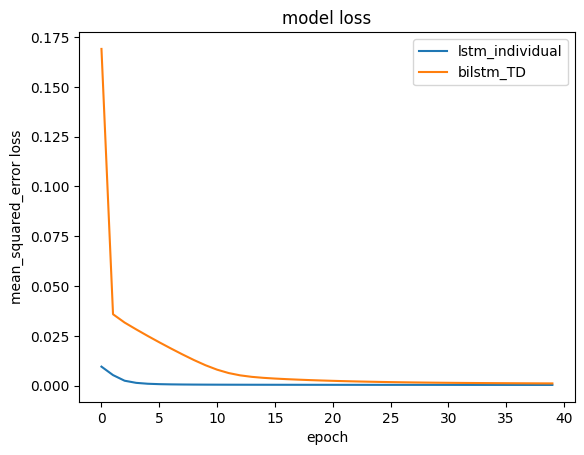

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
# plt.plot(history_batch.history['loss'])
plt.plot(history_TD_bilstm.history['loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error loss')
plt.xlabel('epoch')
plt.legend(['lstm_individual', 'bilstm_TD'], loc='upper right')
plt.show()

In [21]:
y_pred_lstm = lstm.predict(x_test_scaled_re, batch_size=1)

470/470 [==============================] - 0s 427us/step


In [32]:
y_pred_bilstm = bilstm.predict(x_test_scaled_re, batch_size=1)
y_pred_bilstm = y_pred_bilstm.reshape(y_pred_bilstm.shape[0], y_pred_bilstm.shape[2])

470/470 [==============================] - 0s 439us/step


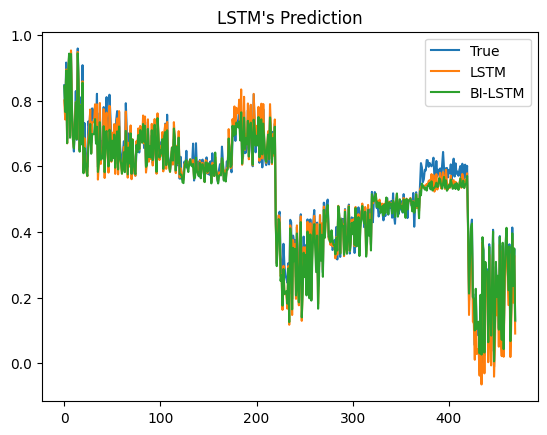

In [33]:
plt.plot(y_test_scaled, label="True")
plt.plot(y_pred_lstm, label="LSTM")
plt.plot(y_pred_bilstm, label="BI-LSTM")
plt.title("LSTM's Prediction")
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluating the model
def evaluate_model(y_test, y_pred):
    # Calculating regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = (
        2 * np.mean(np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test)))
    ) * 100
    r2 = r2_score(y_test, y_pred)

    results = {
        "y_test_pred": y_pred.tolist(),
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "mape": mape,
        "smape": smape,
        "r2": r2,
    }

    return results

In [35]:
# Print evaluation results
def print_evaluation_results(model_name, results):

    print(f"{model_name} Evaluation on Test Set:")
    print(f'Mean Absolute Error (MAE): {results.get("mae", "N/A")}')
    print(f'Mean Squared Error (MSE): {results.get("mse", "N/A")}')
    print(f'Root Mean Squared Error (RMSE): {results.get("rmse", "N/A")}')
    print(f'Mean Absolute Percentage Error (MAPE): {results.get("mape", "N/A")}%')
    print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {results.get("smape", "N/A")}%')
    print(f'Coefficient of determination (R²): {results.get("r2", "N/A")}')

In [36]:
results = evaluate_model(y_test_scaled, y_pred_lstm)
print_evaluation_results("LSTM", results)

LSTM Evaluation on Test Set:
Mean Absolute Error (MAE): 0.02506187331399838
Mean Squared Error (MSE): 0.001021473118590858
Root Mean Squared Error (RMSE): 0.031960493090546306
Mean Absolute Percentage Error (MAPE): 34.04173441462658%
Symmetric Mean Absolute Percentage Error (SMAPE): 9.797809117043148%
Coefficient of determination (R²): 0.9672164477468072


In [37]:
results = evaluate_model(y_test_scaled, y_pred_bilstm)
print_evaluation_results("BI-LSTM", results)

BI-LSTM Evaluation on Test Set:
Mean Absolute Error (MAE): 0.025307774970267906
Mean Squared Error (MSE): 0.0011300598558248436
Root Mean Squared Error (RMSE): 0.033616362917853616
Mean Absolute Percentage Error (MAPE): 16.197504434932263%
Symmetric Mean Absolute Percentage Error (SMAPE): 6.861524903675567%
Coefficient of determination (R²): 0.9637314231198009


In [44]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   960       
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 971 (3.79 KB)
Trainable params: 971 (3.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 20)             1920      
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 1, 1)              21        
 ributed)                                                        
                                                                 
Total params: 1941 (7.58 KB)
Trainable params: 1941 (7.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Inverse transformed data and Reverting the differences to forecasted total sales
def inverse_transform_and_revert_differencing(y_pred, train_data, test_data, scaler):
    y_pred = scaler.inverse_transform(y_pred).ravel()
    # Obtaining forecasted total sales
    last_total_sales_per_item = (
        train_data.groupby("item")["total_sales"].last().to_dict()
    )
    forecasted_total_sales = y_pred.copy()

    for item in last_total_sales_per_item:
        item_indices = test_data["item"] == item
        forecasted_total_sales[item_indices] += last_total_sales_per_item[item]

    return forecasted_total_sales

In [49]:
y_pred_lstm_reverted = inverse_transform_and_revert_differencing(
    y_pred_lstm,
    train,
    test,
    scaler_y,
)

In [53]:
test["pred"] = y_pred_lstm_reverted

In [56]:
test[["item", "total_sales", "pred"]].head()

,item,total_sales,pred
year_month,,,
2017-03,31,18601,17922.087891
2017-03,32,13725,13387.449219
2017-03,33,22095,21784.621094
2017-03,34,8165,7973.204590
2017-03,35,20730,21042.654297


In [64]:
test_plot = test[["total_sales", "pred"]].groupby("year_month").sum().head()

In [66]:
test_plot.head()

,total_sales,pred
year_month,,
2017-03,306052,302946.0625
2017-04,938862,843863.6250
2017-05,1020686,835397.0625
2017-06,1064624,787303.2500
2017-07,1171393,869064.6875


<Axes: xlabel='year_month'>

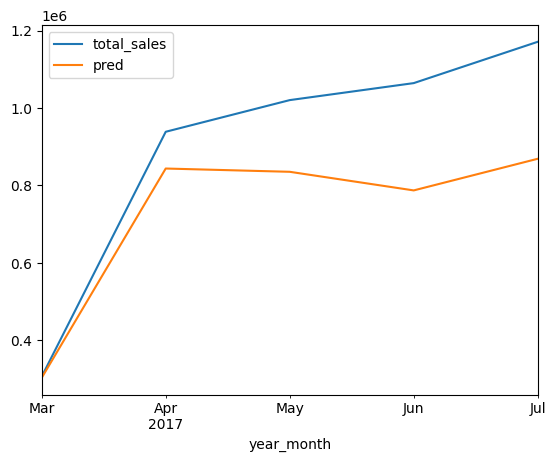

In [78]:
test_plot.plot()

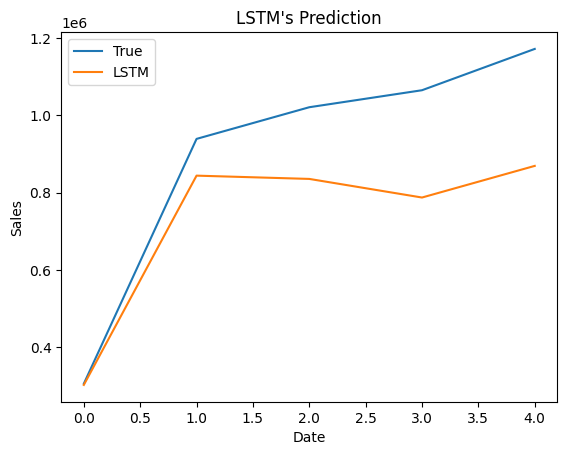

In [77]:
plt.plot(test_plot["total_sales"].values, label="True")
plt.plot(test_plot["pred"].values, label="LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("LSTM's Prediction")
plt.legend()
plt.show()

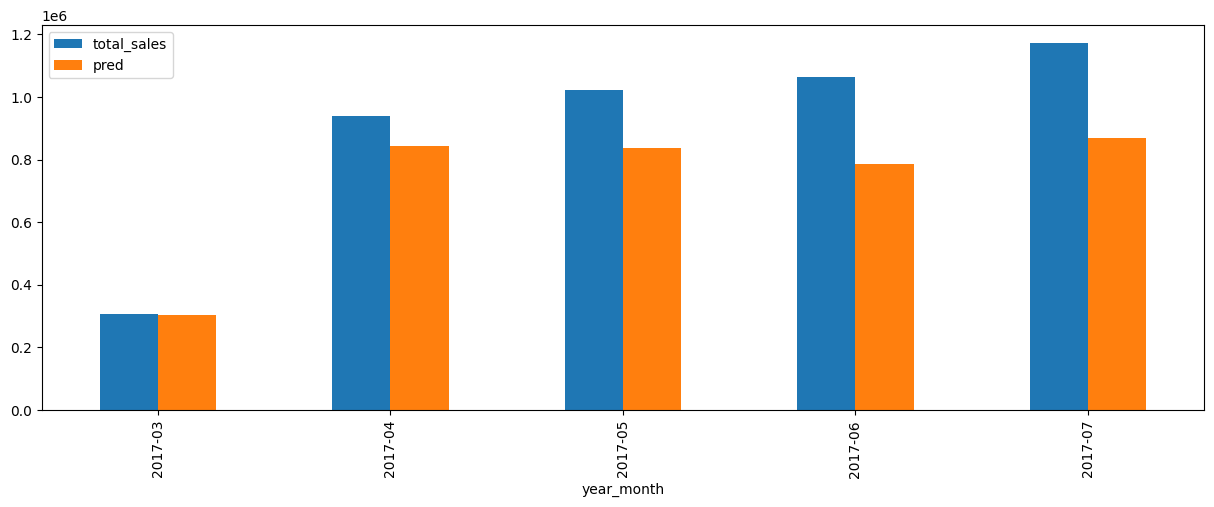

In [68]:
ax = test_plot.plot(kind="bar", figsize=(15, 5))

In [72]:
results = evaluate_model(test["total_sales"], test["pred"])
print_evaluation_results("LSTM", results)

LSTM Evaluation on Test Set:
Mean Absolute Error (MAE): 4600.447950257646
Mean Squared Error (MSE): 32531995.3759461
Root Mean Squared Error (RMSE): 5703.6826152886615
Mean Absolute Percentage Error (MAPE): 24.672791438667733%
Symmetric Mean Absolute Percentage Error (SMAPE): 29.72178874964006%
Coefficient of determination (R²): 0.5250290093294069
